# EECS 498-008/598-008 Assignment 6-4: Style Transfer

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Wenfei TANG, #26621268

# Style Transfer
In this notebook we will implement the style transfer technique from ["Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2015)](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

The general idea is to take two images, and produce a new image that reflects the content of one but the artistic "style" of the other. We will do this by first formulating a loss function that matches the content and style of each respective image in the feature space of a deep network, and then performing gradient descent on the pixels of the image itself.

The deep network we use as a feature extractor is [SqueezeNet](https://arxiv.org/abs/1602.07360), a small model that has been trained on ImageNet. You could use any network, but we chose SqueezeNet here for its small size and efficiency.

Here's an example of the images you'll be able to produce by the end of this notebook:

![caption](http://web.eecs.umich.edu/~justincj/teaching/eecs498/example_styletransfer.png)


# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [2]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['eecs598', 'network_visualization.py', 'style_transfer.py',  'network_visualization.ipynb', 'a6_helper.py', 'pytorch_autograd_and_nn.py', 'pytorch_autograd_and_nn.ipynb', 'style_transfer.ipynb', 'rnn_lstm_attention_captioning.ipynb',  'rnn_lstm_attention_captioning.py']
```

In [4]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A1 folder, then '2020FA/A1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Colab Notebooks/A6"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['style_transfer.ipynb', 'a6_helper.py', 'images', 'eecs598', '__pycache__', 'vae_generation.jpg', 'conditional_vae_generation.jpg', 'variational_autoencoders.ipynb', 'vae.py', 'style_transfer.py', 'style_transfer_result.jpg', 'feature_inversion_result.jpg', 'spatial_style_transfer_result.jpg', 'gan.py', 'fc_gan_results.jpg', 'ls_gan_results.jpg', 'dc_gan_results.jpg', 'generative_adversarial_networks.ipynb', 'network_visualization.py', 'saliency_maps_results.jpg', 'adversarial_attacks_results.jpg', 'class_viz_result.jpg', 'network_visualization.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from style_transfer.py!
```

as well as the last edit time for the file `style_transfer.py`.

In [5]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from style_transfer import *
from a6_helper import *
hello()

py_path = os.path.join(GOOGLE_DRIVE_PATH, 'style_transfer.py')
py_edit_time = time.ctime(os.path.getmtime(py_path))
print('style_transfer.py last edited on %s' % py_edit_time)

Hello from style_transfer.py!
style_transfer.py last edited on Thu Apr 21 02:36:10 2022


### Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [6]:
import torch
import torch.nn as nn
import torchvision
import PIL
import numpy as np
from eecs598.grad import rel_error
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [7]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
to_float_cuda = torch.cuda.FloatTensor 

Good to go!


### Data Setup

Download a few style images and answer checking files. Perform checks for package compatibility with this notebook.

In [8]:
# download imagenet_val
if os.path.isdir('styles'):
  print('Style images exist')
else:
  print('downloading Style images')
  # !wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/a4_styles.zip
  # !wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/styles.zip
  !wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/style_data.zip
  !unzip style_data.zip && rm style_data.zip
  !mv style_data/* . && rm -rf style_data

check_scipy()
answers = dict(np.load('style-transfer-checks.npz'))

downloading Style images
--2022-04-22 00:35:09--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/style_data.zip
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2174844 (2.1M) [application/zip]
Saving to: ‘style_data.zip’

style_data.zip      100%[===================>]   2.07M  5.46MB/s    in 0.4s    

2022-04-22 00:35:10 (5.46 MB/s) - ‘style_data.zip’ saved [2174844/2174844]

Archive:  style_data.zip
   creating: style_data/
  inflating: __MACOSX/._style_data   
  inflating: style_data/style-transfer-checks.npz  
  inflating: __MACOSX/style_data/._style-transfer-checks.npz  
   creating: style_data/styles/
  inflating: __MACOSX/style_data/._styles  
  inflating: style_data/styles/the_scream.jpg  
  inflating: __MACOSX/style_data/styles/._the_scream.jpg  
  inflating: style_data/styles/composition_vii.jpg  
  inflating:

### Backbone Setup

Load a pre-trained backbone model to extract features.

In [9]:
# Load the pre-trained SqueezeNet model.
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(to_float_cuda)

# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False

# We provide this helper code which takes an image, a model (cnn), and returns a list of
# feature maps, one per layer.
def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features


def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = img.type(to_float_cuda)
    return extract_features(img_var, cnn), img_var


#please disregard warnings about initialization

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

# Style Transfer
## Computing Loss

We're going to compute the three components of our loss function now. The loss function is a weighted sum of three terms: content loss + style loss + total variation loss. You'll fill in the functions that compute these weighted terms below.

## Content loss
We can generate an image that reflects the content of one image and the style of another by incorporating both in our loss function. We want to penalize deviations from the content of the content image and deviations from the style of the style image. We can then use this hybrid loss function to perform gradient descent **not on the parameters** of the model, but instead **on the pixel values** of our original image.

Let's first write the content loss function. Content loss measures how much the feature map of the generated image differs from the feature map of the source image. We only care about the content representation of one layer of the network (say, layer $\ell$), that has feature maps $A^\ell \in \mathbb{R}^{1 \times C_\ell \times H_\ell \times W_\ell}$. $C_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width. We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. Let $F^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ be the feature map for the current image and $P^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ be the feature map for the content source image where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image. Finally, let $w_c$ be the weight of the content loss term in the loss function.

Then the content loss is given by:

$L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

Implement the `content_loss` and run the cell below to test it. You should see errors less than 0.001.

In [ ]:
def content_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    content_layer = 3
    content_weight = 6e-2
    
    c_feats, content_img_var = features_from_img(content_image, image_size)
    
    bad_img = torch.zeros(*content_img_var.data.size()).type(to_float_cuda)
    feats = extract_features(bad_img, cnn)
    
    # YOUR_TURN: Impelement the content_loss function
    student_output = content_loss(content_weight, c_feats[content_layer], feats[content_layer])

    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))

content_loss_test(torch.from_numpy(answers['cl_out']).type(to_float_cuda))

Maximum error is 0.000


## Style loss
Now we can tackle the style loss. For a given layer $\ell$, the style loss is defined as follows:

First, compute the Gram matrix G which represents the correlations between the responses of each filter, where F is as above. The Gram matrix is an approximation to the covariance matrix -- we want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to do that. There are a variety of ways you could do this, but the Gram matrix is nice because it's easy to compute and in practice shows good results.

Given a feature map $F^\ell$ of shape $(C_\ell, M_\ell)$, the Gram matrix has shape $(C_\ell, C_\ell)$ and its elements are given by:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$

Assuming $G^\ell$ is the Gram matrix from the feature map of the current image, $A^\ell$ is the Gram Matrix from the feature map of the source style image, and $w_\ell$ a scalar weight term, then the style loss for the layer $\ell$ is simply the weighted Euclidean distance between the two Gram matrices:

$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

In practice we usually compute the style loss at a set of layers $\mathcal{L}$ rather than just a single layer $\ell$; then the total style loss is the sum of style losses at each layer:

$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$

Begin by implementing `gram_matrix` and run the cell below to test it. You should see errors less than 0.001.

In [ ]:
def gram_matrix_test(correct):
    style_image = 'styles/starry_night.jpg'
    style_size = 192
    feats, _ = features_from_img(style_image, style_size)
    # YOUR_TURN: Impelement the gram_matrix function
    student_output = gram_matrix(feats[5].clone())
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))

gram_matrix_test(torch.from_numpy(answers['gm_out']).type(to_float_cuda))

Maximum error is 0.000


Next, implement the `style_loss` and run the cell below to test it. The error should be less than 0.001.

In [ ]:
def style_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    style_image = 'styles/starry_night.jpg'
    image_size =  192
    style_size = 192
    style_layers = [1, 4, 6, 7]
    style_weights = [300000, 1000, 15, 3]
    
    c_feats, _ = features_from_img(content_image, image_size)    
    feats, _ = features_from_img(style_image, style_size)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))
    # YOUR_TURN: Impelement the style_loss function
    student_output = style_loss(c_feats, style_layers, style_targets, style_weights)
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))

    
style_loss_test(torch.from_numpy(answers['sl_out']).type(to_float_cuda))

Error is 0.000


## Total-variation regularization
It turns out that it's helpful to also encourage smoothness in the image. We can do this by adding another term to our loss that penalizes wiggles or "total variation" in the pixel values. 

You can compute the "total variation" as the sum of the squares of differences in the pixel values for all pairs of pixels that are next to each other (horizontally or vertically). Here we sum the total-variation regularization for each of the 3 input channels (RGB), and weight the total summed loss by the total variation weight, $w_t$:

$L_{tv} = w_t \times \left(\sum_{c=1}^3\sum_{i=1}^{H-1}\sum_{j=1}^{W} (x_{i+1,j,c} - x_{i,j,c})^2 + \sum_{c=1}^3\sum_{i=1}^{H}\sum_{j=1}^{W - 1} (x_{i,j+1,c} - x_{i,j,c})^2\right)$

Now, implement the `tv_loss` and test it. Error should be less than 0.0001. To receive full credit, your implementation should not have any loops.

In [ ]:
def tv_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    tv_weight = 2e-2

    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(to_float_cuda)
    
    student_output = tv_loss(content_img, tv_weight)
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))
    
tv_loss_test(torch.from_numpy(answers['tv_out']).type(to_float_cuda))

Error is 0.000


Now we're ready to string it all together (you shouldn't have to modify this function):

In [ ]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False, save_image=False, result_filename=None):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    - save_image: boolean flag for saving the image
    """
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(to_float_cuda)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size).type(to_float_cuda)
    feats = extract_features(style_img, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(to_float_cuda)
    else:
        img = content_img.clone().type(to_float_cuda)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    if save_image:
      plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,result_filename))
    plt.show() 

## Generate some pretty pictures!

Try out `style_transfer` on the three different parameter sets below. Make sure to run all three cells. Feel free to add your own, but make sure to include the results of style transfer on the third parameter set (starry night) in your submitted notebook.

* The `content_image` is the filename of content image.
* The `style_image` is the filename of style image.
* The `image_size` is the size of smallest image dimension of the content image (used for content loss and generated image).
* The `style_size` is the size of smallest style image dimension.
* The `content_layer` specifies which layer to use for content loss.
* The `content_weight` gives weighting on content loss in the overall loss function. Increasing the value of this parameter will make the final image look more realistic (closer to the original content).
* `style_layers` specifies a list of which layers to use for style loss. 
* `style_weights` specifies a list of weights to use for each layer in style_layers (each of which will contribute a term to the overall style loss). We generally use higher weights for the earlier style layers because they describe more local/smaller scale features, which are more important to texture than features over larger receptive fields. In general, increasing these weights will make the resulting image look less like the original content and more distorted towards the appearance of the style image.
* `tv_weight` specifies the weighting of total variation regularization in the overall loss function. Increasing this value makes the resulting image look smoother and less jagged, at the cost of lower fidelity to style and content. 

Below the next three cells of code (in which you shouldn't change the hyperparameters), feel free to copy and paste the parameters to play around them and see how the resulting image changes. You will be submitting the style transfer result from the first test for evaluation. Final image will be saved and zipped automatically.

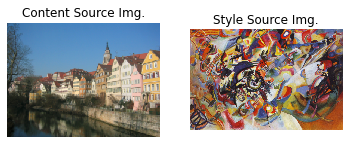

Iteration 0


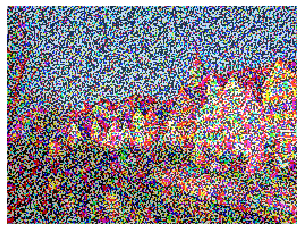

Iteration 100


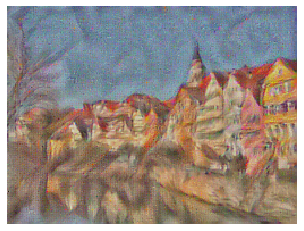

Iteration 199


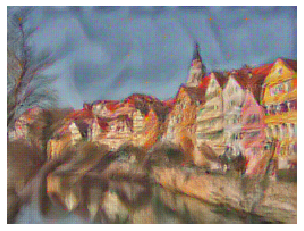

In [ ]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2,
    'save_image' : True,
    'result_filename' : 'style_transfer_result.jpg'
}

style_transfer(**params1)

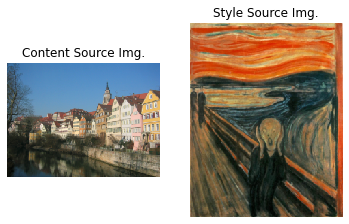

Iteration 0


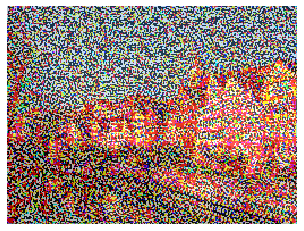

Iteration 100


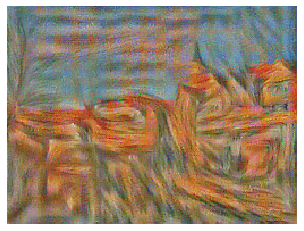

Iteration 199


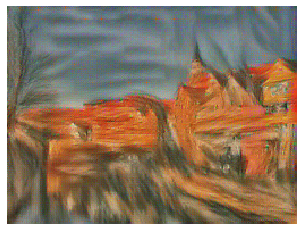

In [ ]:
# Scream + Tubingen
params2 = {
    'content_image':'styles/tubingen.jpg',
    'style_image':'styles/the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2,
    'save_image' : False
}

style_transfer(**params2)

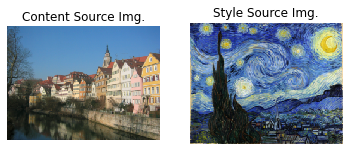

Iteration 0


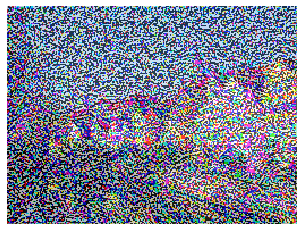

Iteration 100


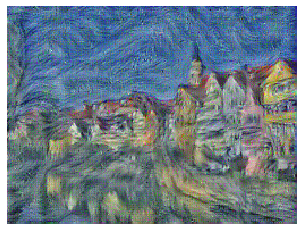

Iteration 199


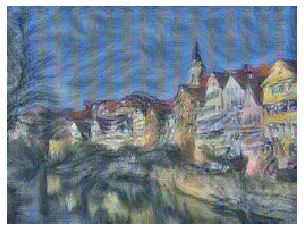

In [ ]:
# Starry Night + Tubingen
params3 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2,
    'save_image' : False
}

style_transfer(**params3)

## Feature Inversion

The code you've written can do another cool thing. In an attempt to understand the types of features that convolutional networks learn to recognize, a recent paper [1] attempts to reconstruct an image from its feature representation. We can easily implement this idea using image gradients from the pretrained network, which is exactly what we did above (but with two different feature representations).

Now, if you set the style weights to all be 0 and initialize the starting image to random noise instead of the content source image, you'll reconstruct an image from the feature representation of the content source image. You're starting with total noise, but you should end up with something that looks quite a bit like your original image.

(Similarly, you could do "texture synthesis" from scratch if you set the content weight to 0 and initialize the starting image to random noise, but we won't ask you to do that here.) 

Run the following cell to try out feature inversion and you will submit the result for evaluation. Final image will be saved and zipped automatically.

[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting them", CVPR 2015


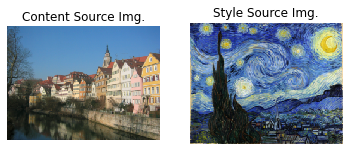

Iteration 0


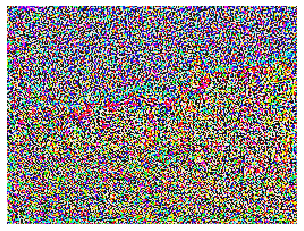

Iteration 100


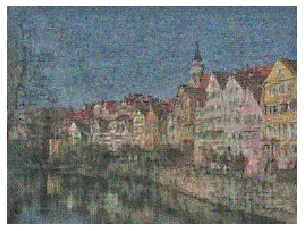

Iteration 199


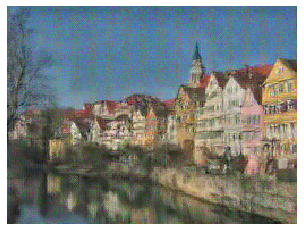

In [ ]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True, # we want to initialize our image to be random
    'save_image' : True,
    'result_filename' : 'feature_inversion_result.jpg'
}

style_transfer(**params_inv)

# Challenge: Spatial Style Transfer
**Note: This part only occupies 3% of the whole assignment and won't affect your grade very much. Feel free to skip it.**

In this section we will extend the above style transfer technique to introduce control over spatial location, referring to ["Controlling Perceptual Factors in Neural Style Transfer" (Gatys et al., CVPR 2017)](https://openaccess.thecvf.com/content_cvpr_2017/papers/Gatys_Controlling_Perceptual_Factors_CVPR_2017_paper.pdf).

The general idea of this technique is that instead of getting the artistic style from the whole style image and applying it to the whole content image, we want to acquire the style of a particular region from the style image, and apply it to a corresponding region in the content image. For example, if both our style and content images consist of a sky part and a house part, this technique helps us apply the sky style from the style image to the sky of the content image (see Fig. 2 in the paper).

## Guided Gram Matrix
We multiply the feature maps of each layer included in the style features with $R$ guidance channels $T_{\ell}^r$. A guidance channel is just a image map with [0, 1] values specifying which region gets which style. In other words, the region where the $r^{th}$ content guidance channel equal to one should get the style from the region where the $r^{th}$ style guidance channel equal to 1. With that being said, in this simplified homework problem, we only have $R = 2$, thus we have binary guidance channels. A spatially guided feature map is computed as:

$$F_{\ell}^{r}[:,i] = T_\ell^r \circ F_\ell[:i]$$

Here $F_{\ell}^{r}[:,i]$ means the $i^{th}$ column of $F_\ell^r$ and $\circ$ denotes element-wise multiplication. The guided Gram Matrix then becomes:

$$G_\ell^r = (F_\ell^r)^T F_\ell^r$$

Implement the `guided_gram_matrix` function and test with the cell below, you should see an error less than `1e-4`.

In [ ]:
sample_feats = torch.tensor(
  [[[[[-0.6119, -0.8243, -0.5697],
      [-1.3241, -0.0453, -0.3629],
      [-0.3321,  0.7076, -0.3311]],

      [[ 0.6079, -0.2566,  1.3993],
      [ 1.0103, -1.2616, -1.5729],
      [-0.0624,  0.4101,  0.4085]],

      [[-1.2122,  0.3690, -0.0933],
      [ 1.7902, -0.3964, -1.4309],
      [ 0.6862,  0.3385,  0.0479]]],


      [[[-0.0679, -1.1770,  0.3031],
      [ 1.9585, -0.2974, -1.1080],
      [-0.8019,  1.3293,  0.3496]],

      [[-1.5403, -1.7125,  0.0887],
      [-0.7244,  0.8991,  0.6955],
      [-1.3828, -0.2718, -1.6329]],

      [[-0.5770, -0.0657,  0.5746],
      [-0.1939,  0.4295, -0.7639],
      [ 0.3080, -0.8542,  0.6180]]]]]
)

sample_mask = torch.triu(torch.ones((1, 2, 3, 3)))
expected_answer = torch.tensor(
  [[[[ 0.0601, -0.0172,  0.0375],
    [-0.0172,  0.2454,  0.0670],
    [ 0.0375,  0.0670,  0.1415]],

   [[ 0.1082,  0.0199,  0.0454],
    [ 0.0199,  0.3434, -0.0038],
    [ 0.0454, -0.0038,  0.0673]]]]
)
student_answer = guided_gram_matrix(sample_feats, sample_mask)
error = rel_error(expected_answer, student_answer)
print(f'loss error: {error}')

loss error: 6.794367359889579e-05


## Guided Style loss
After the above guided Gram Matrices are calculated, each of them is now used as the optimization target for the corresponding region of the content image. The style loss for the layer $\ell$ then becomes:

$$L_s^\ell = w_\ell \sum_{r=1}^R\sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

Implement the `guided_style_loss` function. It should be almost the same as your `style_loss` function for the original style transfer, except you are now using `guided_gram_matrix` for it. You should see an error less than `1e-6`.

In [ ]:
sample_target = torch.tensor(
  [[[[ 1.6195,  0.8610, -0.2706],
  [ 0.2184, -0.8091, -0.0450],
  [-0.0359,  1.7087,  1.7617]],

  [[ 1.6495,  1.1240,  1.1872],
  [-0.0577, -1.1156, -0.0601],
  [-0.7020,  0.4917, -0.3774]]]]
)

expected_answer = torch.tensor(267.6274)
student_answer = guided_style_loss(
    [sample_feats], [0], [sample_target], [15], [sample_mask]
)
error = rel_error(expected_answer, student_answer)
print(f'loss error: {error}')

loss error: 5.701503919897975e-08


## Generate Some Images!
Now you have implemented everything we need. You can run the below cells to check how the result looks like. In this example, there are two style images, and we are trying to apply the style of house in style1 and the style of sky in style2 to the house and sky in the content image. Essentially it should be similar to Fig.2(f) in the paper.

First run some useful functions for the spatial style transfer.

In [ ]:
def get_image_masks(img_paths, img_size):
  masks = []
  for path in img_paths:
    masks.append(
      get_zero_one_masks(PIL.Image.open(path), image_size).type(to_float_cuda)
    )
  return torch.cat(masks, 0)
  
def extract_layer_masks(features, masks):
  layer_masks = []

  for feat in features:
    feat_height, feat_width = feat.shape[-2], feat.shape[-1]
    feat_transform = T.Resize((feat_height, feat_width))
    feat_masks = feat_transform(masks)
    layer_masks.append(feat_masks)

  return layer_masks


def extract_regional_features(x, cnn, R=2):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    - R: stack the features R times to generate the image region guidance
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, R, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat.unsqueeze(1).repeat(1, R, 1, 1, 1))
        prev_feat = next_feat
    return features


def guided_style_transfer(content_image, style_images, image_size, style_size, 
                   content_layer, content_weight, content_masks,
                   style_layers, style_weights, style_masks, tv_weight, 
                   init_random = False, save_image=False, result_filename=None):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_images: list of filenames of style images
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - content_masks: binary masks of the content image for the corresponding regions
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - style_masks: binary masks of the sylte image for the corresponding regions
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    - save_image: boolean flag for saving the image
    """
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(to_float_cuda)
    feats = extract_regional_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style images
    # For this simplified assignment problem, we use 2 style images
    style1_img, style2_img = [
      preprocess(PIL.Image.open(style_image), size=style_size).type(to_float_cuda)
      for style_image in style_images
    ]
    style1_feats = extract_features(style1_img, cnn)
    style2_feats = extract_features(style2_img, cnn)

    # generate content mask for each shape of the style features
    content_masks = extract_layer_masks(style1_feats, content_masks)

    # Stack style features
    feats = []
    for i in range(len(style1_feats)):
        style_feats = torch.stack((style1_feats[i], style2_feats[i]), dim=1)
        feats.append(style_feats)
    style_masks = extract_layer_masks(feats, style_masks)
    
    style_targets = []
    for idx in style_layers:
        style_targets.append(guided_gram_matrix(feats[idx].clone(), style_masks[idx]))

    # Initialize output image to content image or noise
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(to_float_cuda)
    else:
        img = content_img.clone().type(to_float_cuda)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1, 3)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style1 Source Img.')
    axarr[2].set_title('Style2 Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style1_img.cpu()))
    axarr[2].imshow(deprocess(style2_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_regional_features(img, cnn)

        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = guided_style_loss(feats, style_layers, style_targets, style_weights, content_masks)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss

        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    if save_image:
        plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,result_filename))
    plt.show() 

Load some images, including the spatial guidance masks, the content image, and the style images that we will be using.

In [ ]:
image_folder_path = os.path.join(GOOGLE_DRIVE_PATH, 'images')
image_size = (192, 288)
content_sky_mask_path = os.path.join(image_folder_path, 'fig2_content_sky.jpg')
content_nosky_mask_path = os.path.join(image_folder_path, 'fig2_content_nosky.jpg')
content_masks = get_image_masks([content_nosky_mask_path, content_sky_mask_path], image_size).unsqueeze(0)
style1_nosky_mask_path = os.path.join(image_folder_path, 'fig2_style1_nosky.jpg')
style2_sky_mask_path = os.path.join(image_folder_path, 'fig2_style2_sky.jpg')
style_masks = get_image_masks([style1_nosky_mask_path, style2_sky_mask_path], image_size).unsqueeze(0)

content_image_path = os.path.join(image_folder_path, 'fig2_content.jpg')
style1_image_path = os.path.join(image_folder_path, 'fig2_style1.jpg')
style2_image_path = os.path.join(image_folder_path, 'fig2_style2.jpg')

Below are the parameters that we used to generate the spatial style transfer result. You can switch the order of masks when to apply styles to different regions and get a better understanding of how this works. But the image themselves cannot be change, as the spatial guidance masks are pre-generated.

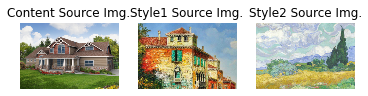

Iteration 0


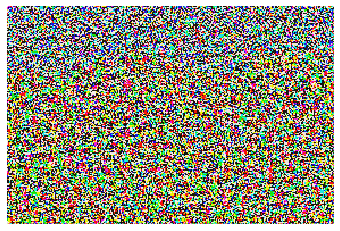

Iteration 100


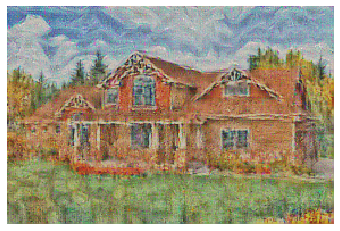

Iteration 199


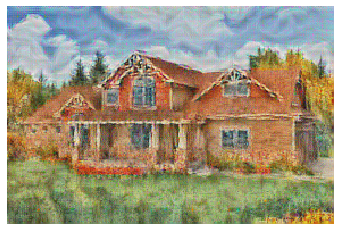

In [ ]:
# Spatial Style Transfer
params_inv = {
    'content_image' : content_image_path,
    'style_images' : [style1_image_path, style2_image_path],
    'image_size' : (192, 288),
    'style_size' : (192, 288),
    'content_layer' : 3,
    'content_weight': 2e-2,
    'content_masks': content_masks,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    # 'style_weights': [0, 0, 0, 0],
    'style_masks': style_masks,
    'tv_weight' : 2e-2,
    'init_random': True, # we want to initialize our image to be random
    'save_image' : True,
    'result_filename': 'spatial_style_transfer_result.jpg'
}

guided_style_transfer(**params_inv)

# Final checks
Make sure all your training results (loss + images) are saved in the notebook. You can run "Runtime -> Restart and run all..." to double check before submitting

# Submit Your Work

After completing all the notebooks for this assignment, run the following cell to create a .zip file for you to download and turn in. Please MANUALLY SAVE every *.ipynb and *.py files before executing the following cell:

In [10]:
from eecs598.submit import make_a6_submission

# TODO: Replace these with your actual uniquename and umid
uniquename = "twenfei"
umid = "26621268"
make_a6_submission(GOOGLE_DRIVE_PATH, uniquename, umid)

Writing zip file to:  drive/My Drive/Colab Notebooks/A6/twenfei_26621268_A6.zip
